In [1]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
SummaryWriter

In [53]:
import torch
from torchmetrics.classification import AUROC, F1Score, PrecisionRecallCurve

preds = torch.tensor([[0.4, 0.6], [0.6, 0.4], [0.3, 0.7], [0.8, 0.2]])
target = torch.tensor([0, 1, 1, 0])
f1 = F1Score(task="multiclass", num_classes=2, average="none")
f1(preds, target)

tensor([0.5000, 0.5000])

In [56]:
auroc = AUROC("multiclass", thresholds=20, num_classes=2, average="macro")
auroc(preds, target)

tensor(0.7500)

In [26]:
pr_curve = PrecisionRecallCurve(task="binary", thresholds=20)
p, r, t = pr_curve(preds[:, 1], target)

In [30]:
p

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.6667, 0.6667, 0.5000, 0.5000, 0.5000,
        0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000])

In [27]:
import seaborn as sns

<Axes: >

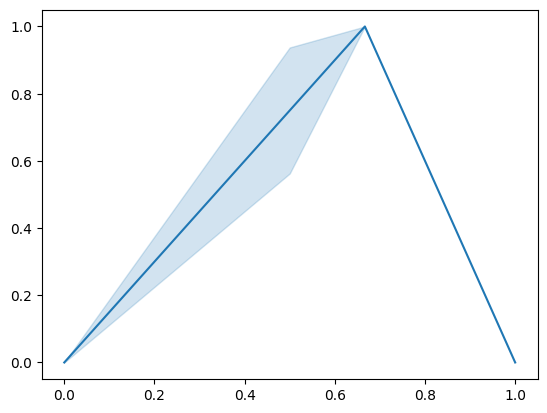

In [29]:
sns.lineplot(x=p.numpy(), y=r.numpy())

In [24]:
from sklearn.metrics import classification_report

p, r, f, s = precision_recall_fscore_support(target.numpy(), preds.numpy())
print(classification_report(target.numpy(), preds.numpy()))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2

    accuracy                           0.33         6
   macro avg       0.22      0.33      0.27         6
weighted avg       0.22      0.33      0.27         6



In [25]:
p

array([0.66666667, 0.        , 0.        ])

In [98]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    precision_recall_fscore_support,
)

In [9]:
df = pd.read_csv(
    "../outputs/multirun/dry_run/wiki_toxic/igalgradnorm_2023-05-14T21-04-27/logs/test/instance_level.csv"
)
labels = load_dataset("pietrolesci/wiki_toxic_indexed")["test"].to_pandas()

Found cached dataset parquet (/home/pl487/.cache/huggingface/datasets/pietrolesci___parquet/pietrolesci--wiki_toxic_indexed-bbeb1b8d65bf4665/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [63]:
path = Path("../outputs/multirun/dry_run/wiki_toxic/")

In [67]:
list(path.glob("randomstrategy*"))

[PosixPath('../outputs/multirun/dry_run/wiki_toxic/randomstrategy_2023-05-14T21-04-27')]

/home/pl487/.conda/envs/igal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pl487/.conda/envs/igal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pl487/.conda/envs/igal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


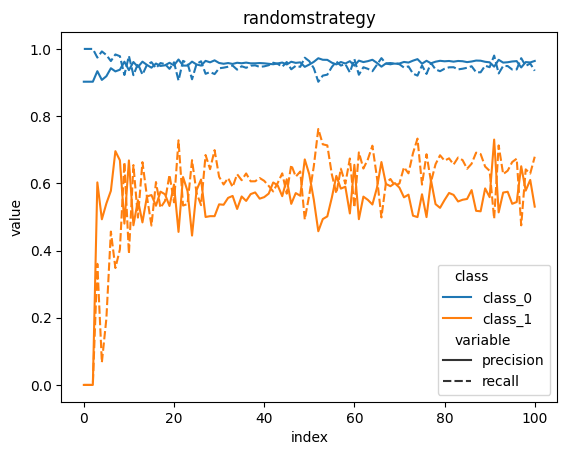

/home/pl487/.conda/envs/igal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


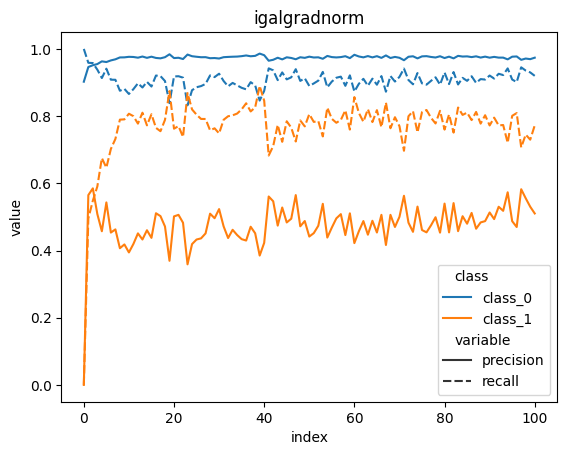

/home/pl487/.conda/envs/igal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


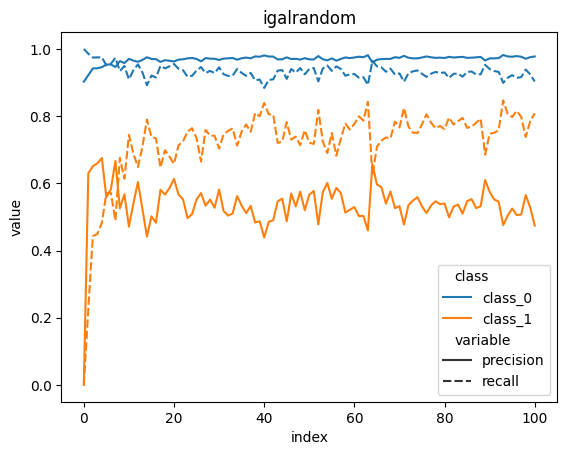

/home/pl487/.conda/envs/igal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


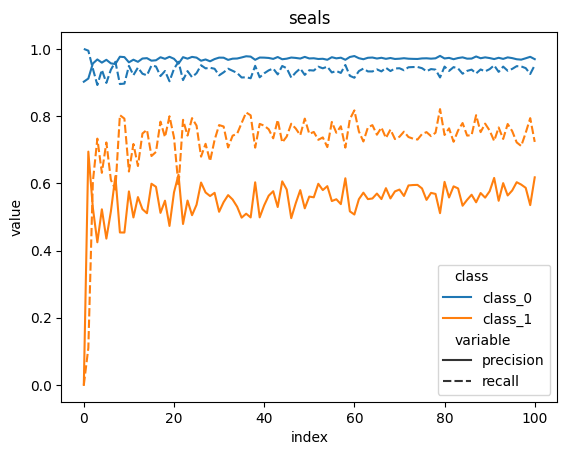

In [75]:
results = {}

for name in ("randomstrategy", "igalgradnorm", "igalrandom", "seals"):

    data_path = list(path.glob(f"{name}*"))[0]

    df = pd.read_csv(data_path / "logs" / "test" / "instance_level.csv")
    df = pd.merge(df, labels[["uid", "labels"]], on="uid", how="left")
    df["preds"] = np.argmax(df.iloc[:, :2].values, axis=1)

    res = df.groupby("round").apply(
        lambda _df: precision_recall_fscore_support(_df["labels"], _df["preds"])
    )

    r = pd.DataFrame(zip(*list(res.values))).T
    r.columns = ["precision", "recall", "f1", "support"]
    r = r.reset_index().melt(id_vars="index")
    r["class_0"], r["class_1"] = list(zip(*r["value"].values))
    r = r.drop(columns=["value"])
    r = r.melt(id_vars=["index", "variable"], var_name="class")
    results[name] = r

    sns.lineplot(
        data=r.loc[r["variable"].isin(["precision", "recall"])],
        x="index",
        y="value",
        hue="class",
        style="variable",
    )

    plt.title(name)
    plt.show()

In [96]:
pr = pd.concat(
    [
        v.loc[v["variable"].isin(["precision", "recall", "f1"])].assign(name=k)
        for k, v in results.items()
    ]
)

(0.4, 0.7002513104042507)

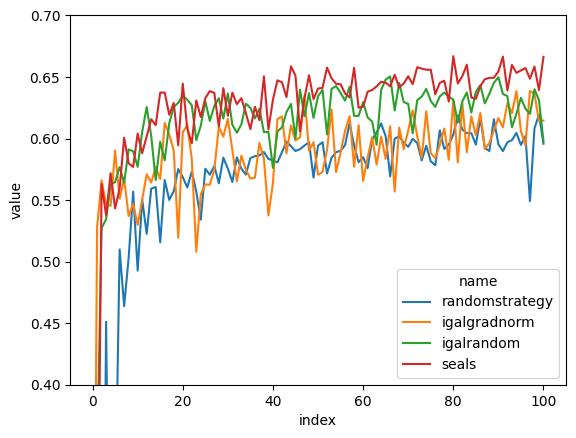

In [97]:
sns.lineplot(
    data=pr.loc[(pr["class"] == "class_1") & (pr["variable"] == "f1")],
    x="index",
    y="value",
    hue="name",
)
plt.ylim(0.4, None)

In [ ]:
gdf = df.groupby("round").apply(
    lambda _df: classification_report(_df["labels"], _df["pred"], output_dict=True)
)

In [ ]:
gdf = gdf.to_frame()

In [ ]:
res = gdf.join(pd.DataFrame(gdf.pop(0).values.tolist()))

In [ ]:
res.iloc[:, 1].to_frame()

In [ ]:
positive_class = 1
train_df = load_dataset("pietrolesci/wiki_toxic_indexed")["train"].to_pandas()

In [ ]:
print("Base rate of the minority class")
(train_df["labels"] == positive_class).mean()

In [ ]:
dataset = "pubmed"
data_path = Path("../outputs/dry_run") / dataset

results = {
    p.parents[1].name.split("_")[0]: pd.read_parquet(p)
    for p in data_path.rglob("*labelled_dataset.parquet")
}

In [ ]:
print("Ability to find minority classes")
{k: (v["labels"] == 1).mean() for k, v in results.items()}

In [ ]:
df = results["igalrandom"]

In [ ]:
pdf = df.groupby("labelling_round")["labels"].value_counts().to_frame().unstack(1)

In [ ]:
pdf.columns = pdf.columns.get_level_values(1)

In [ ]:
pdf.apply(lambda row: row / pdf.sum(1), axis=0)

In [ ]:
(df["labels"] == 1).mean()

In [ ]:
df